In [19]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import clmm
import galsim
import numpy as np
import descwl_shear_sims as dss
import matplotlib.pyplot as plt

from descwl_shear_sims.galaxies import WLDeblendGalaxyCatalog
from descwl_shear_sims.objlists import get_objlist
from descwl_shear_sims.surveys import get_survey

In [58]:
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel

zl_list = [0.1, 0.4]
M200_list = [1e14, 1e15]


g_max = 0.6

class ShearNFW(object):
    def __init__(self, zl_list, M200_list, c_list, cosmo):
        if not isinstance(zl_list, list):
            if isinstance(zl_list, float):
                zl_list = [zl_list]
        if not isinstance(M200_list, list):
            if isinstance(M200_list, float):
                M200_list = [M200_list]
        if not isinstance(c_list, list):
            if isinstance(c_list, float):
                c_list = [c_list]
        assert len(zl_list) == len(M200_list)
        assert len(zl_list) == len(c_list)
        self.cosmo = cosmo
        self.zl_list = zl_list
        self.params = []
        self.n_halos = len(zl_list)
        for _ in range(self.n_halos):
            self.params.append({"M": M200_list[_], "c": c_list[_]})
        return

    def get_shear(self, redshift, shift):
        """
        A shear wrapper to return g1 and g2 with different shear type

        Parameters
        ----------
        redshift (float):           redshifts of galaxies
        shift (galsim.positionD):   Galsim positionD shift [arcsec]

        Returns
        ---------
        shear (galsim.Shear)        shear distortion on the galaxy
        """

        model_list = []
        kwargs_list = []
        for _ in range(self.n_halos):
            model_list.append("NFW")
            lens_cosmo = LensCosmo(z_lens=zl_list[_], z_source=redshift, cosmo=self.cosmo)
            Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(**self.params[_])
            rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(Rs_angle, alpha_Rs)
            kwargs = {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, "center_x": 0.0, "center_y": 0.0}
            kwargs_list.append(kwargs)
        lens = LensModel(lens_model_list=model_list)
        alpha_x, alpha_y = lens.alpha(x=shift.x, y=shift.y, kwargs=kwargs_list)
        f_xx, f_xy, f_yx, f_yy = lens.hessian(x=shift.x, y=shift.y, kwargs=kwargs_list)
        gamma1 = 0.5 * (f_xx - f_yy)
        gamma2 = f_xy
        kappa = 0.5 * (f_xx + f_yy)
        g1 = gamma1 #/ (1 - kappa)
        g2 = gamma2 #/ (1 - kappa)
        # we are forcing g to be less than g_max
        g = np.sqrt(g1 ** 2. + g2 ** 2.)
        ratio = min(g_max / g, 1.0)
        # and rescale g1 and g2 if g > g_max
        g1 = g1 * ratio
        g2 = g2 * ratio
        shear = galsim.Shear(g1=g1, g2=g2)
        return shear

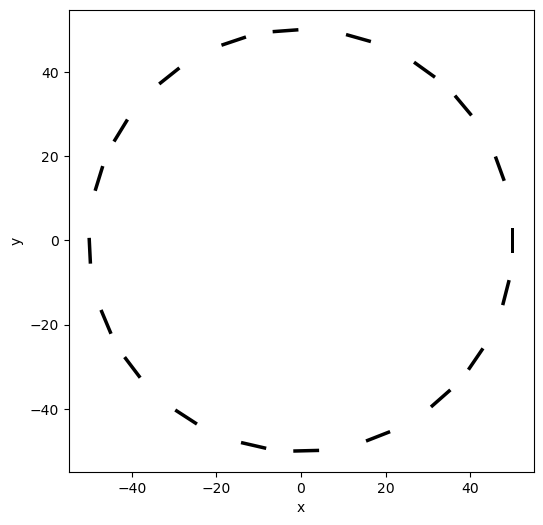

In [59]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
halo = clmm.Modeling(massdef="critical", delta_mdef=200, halo_profile_model="nfw")
halo.set_cosmo(cosmo)
halo.set_concentration(4)
halo.set_mass(1.0e15)
z_cl = 1.0
# source properties
z_source = 2.0  # all sources in the same plane

shear_obj = dss.shear.ShearNFW(halo, z_cl)
# generate positions
radius = 50 # arcsec
n_gal = 20
theta = np.linspace(0, 360, n_gal) / n_gal
x = np.cos(theta) * radius
y = np.sin(theta) * radius
shifts = np.zeros(n_gal, dtype=[('dx', 'f8'), ('dy', 'f8')])
shifts['dx'] = x
shifts['dy'] = y

shift_list = []
for ss in shifts:
    shift_list.append(galsim.PositionD(ss['dx'], ss['dy']))

# get the shear
shear_list = []
for ss in shift_list:
    shear_list.append(shear_obj.get_shear(z_source, ss))

gamma = []
for ss in shear_list:
    gamma.append(ss.g1 + 1j * ss.g2) 
gamma = np.array(gamma)

angles = np.angle(gamma, deg=True) / 2.
lengths = np.abs(gamma) * 100.

# Create whisker plot
plt.figure(figsize=(6, 6))
plt.quiver(x, y, np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles)),
           color="black", headaxislength=0, headlength=0, headwidth=1, pivot = 'middle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

[     1      3      9     27     81    243    729   2187   6561  19683
  59049 177147]
[2.78361124e-01 2.74640017e-01 2.56551659e-01 1.98359090e-01
 1.02796620e-01 3.27933044e-02 7.20665320e-03 1.26455112e-03
 1.95016137e-04 2.78421302e-05 3.78395338e-06 4.97313342e-07]


Text(0, 0.5, '$|g|$')

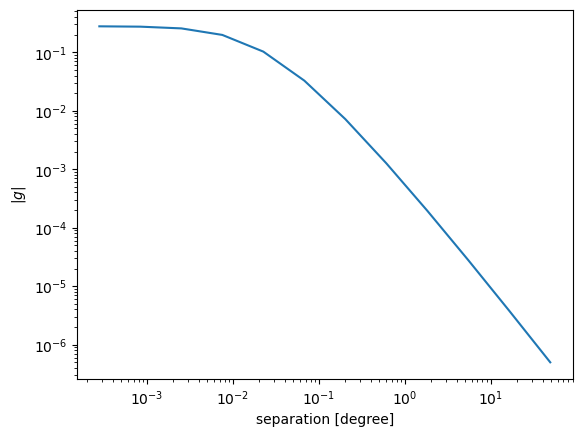

In [60]:
n_gal = 1
d_array = []
g_array = []
for i in range(12):
    position = galsim.PositionD(3.0 ** i, 0.)
    # get the shear
    shear = shear_obj.get_shear(z_source, position)
    g1 = shear.g1
    g2 = shear.g2
    gabs = np.abs(g1 + 1j * g2)
    d_array.append(3 ** i)
    g_array.append(gabs)
d_array = np.array(d_array)
g_array = np.array(g_array)

print(d_array)
print(g_array)
plt.close()
fig, ax = plt.subplots()
ax.plot(d_array / 3600., g_array)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("separation [degree]")
ax.set_ylabel(r"$|g|$")

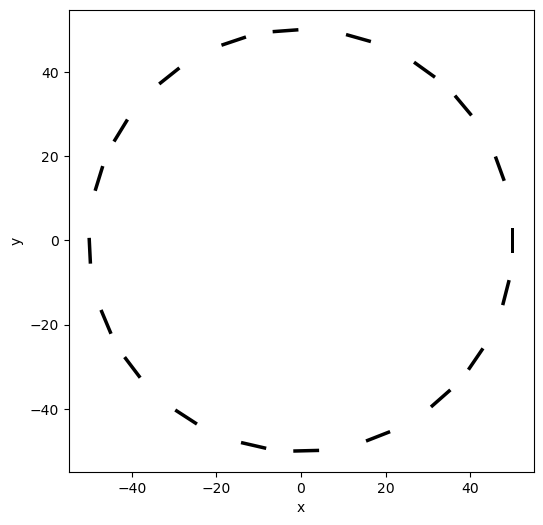

In [61]:
cosmo = FlatLambdaCDM(H0=70.0, Om0=0.27, Ob0=0.045)

shear_obj = ShearNFW(zl_list=[1.], M200_list=[1e15], c_list=[4.0], cosmo=cosmo)
# generate positions
radius = 50 # arcsec
n_gal = 20
theta = np.linspace(0, 360, n_gal) / n_gal
x = np.cos(theta) * radius
y = np.sin(theta) * radius
shifts = np.zeros(n_gal, dtype=[('dx', 'f8'), ('dy', 'f8')])
shifts['dx'] = x
shifts['dy'] = y

shift_list = []
for ss in shifts:
    shift_list.append(galsim.PositionD(ss['dx'], ss['dy']))

# get the shear
shear_list = []
for ss in shift_list:
    shear_list.append(shear_obj.get_shear(z_source, ss))
    
gamma = []
for ss in shear_list:
    gamma.append(ss.g1 + 1j * ss.g2) 
gamma = np.array(gamma)

angles = np.angle(gamma, deg=True) / 2.
lengths = np.abs(gamma) * 100.

# Create whisker plot
plt.figure(figsize=(6, 6))
plt.quiver(x, y, np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles)),
           color="black", headaxislength=0, headlength=0, headwidth=1, pivot = 'middle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [62]:
n_gal = 1
d_array = []
g_array = []
for i in range(12):
    position = galsim.PositionD(3.0 ** i, 0.)
    # get the shear
    shear = shear_obj.get_shear(z_source, position)
    g1 = shear.g1
    g2 = shear.g2
    gabs = np.abs(g1 + 1j * g2)
    d_array.append(3 ** i)
    g_array.append(gabs)
d_array = np.array(d_array)
g_array = np.array(g_array)
print(d_array)
print(g_array)
ax.plot(d_array / 3600., g_array)

[     1      3      9     27     81    243    729   2187   6561  19683
  59049 177147]
[8.26751816e-02 8.26215008e-02 8.22711368e-02 8.02829024e-02
 7.16882521e-02 4.92520061e-02 2.14542996e-02 5.89296747e-03
 1.17895828e-03 1.96054091e-04 2.92963630e-05 4.10083070e-06]


In [64]:
d_array = []
g_array = []
ghalo = galsim.NFWHalo(mass=1e15, conc=4, redshift=1.0, omega_m=0.27, omega_lam=0.73)
for i in range(12):
    position = galsim.PositionD(3.0 ** i, 0.)
    # get the shear
    g1, g2 = ghalo.getShear(position, z_source)
    gabs = np.abs(g1 + 1j * g2)
    d_array.append(3 ** i)
    g_array.append(gabs)
d_array = np.array(d_array)
g_array = np.array(g_array)
print(d_array)
print(g_array)
ax.plot(d_array / 3600., g_array)

[     1      3      9     27     81    243    729   2187   6561  19683
  59049 177147]
[2.47424027e-01 5.30458122e-01 4.51641183e+00 3.92914418e-01
 1.43436687e-01 4.35660410e-02 9.72263335e-03 1.73440286e-03
 2.70341617e-04 3.88561182e-05 5.30434563e-06 6.99305314e-07]


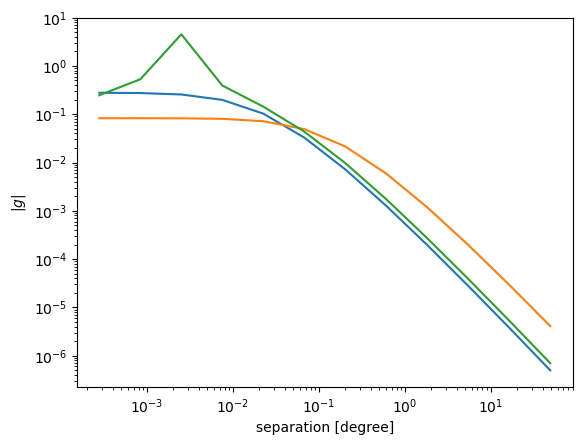

In [65]:
fig